<a href="https://colab.research.google.com/github/eliaashraf/NeurologIQ_Data/blob/main/NIQ_Task.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>




## **Importing all the necessary libraries**











In [ ]:
import numpy as np
import pandas as pd                                                             # saving results csv file
from tqdm import tqdm                                                           #Creates progress bar
import tensorflow as tf
from tensorflow import keras
import matplotlib.pyplot as plt
import cv2
import os                                                                       #To import the name of the file to save results
from PIL import Image                                                           #Python Image Library
from numpy import zeros, newaxis
import glob                                                                     #Finds all the pathnames matching a specified pattern
                                                                                #according to the rules used by the Unix shell
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive')
path_model = "give_path_model"

In [ ]:
cd "directory_with_training_images"



---



##**Creating a data set**

In [3]:
def create_data_set(img_name, height, width):
  img = np.zeros((height, width, 3),dtype=float)
  label = np.zeros((height, width, 1))
  img = cv2.imread(img_name)
  gray = cv2.cvtColor(img, cv2.COLOR_BGR2GRAY)
  thres, bw = cv2.threshold(gray, 100, 255, cv2.THRESH_BINARY_INV)
  bw = bw[:,:,newaxis] # need to add this extra dimension to match the dimension of the label
  #print(np.shape(bw))

  #Randomly snip out parts from an image to create a wider dataset and label from each image to train the model
  contours, hierarchy = cv2.findContours(bw, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
  label = bw.copy()
  cv2.drawContours(label, contours, -1, color=(255, 255, 255), thickness=1)
  x = np.random.randint(0, 1200) 
  y = np.random.randint(0, 1200)

  img = img[x:x+height,y:y+width] 
  label = label[x:x+height,y:y+width]

  #normalisation of image and label
  img = img.astype(float)
  img = img/255.0
  label = label.astype(float)
  label = label/255.0
  return img, label

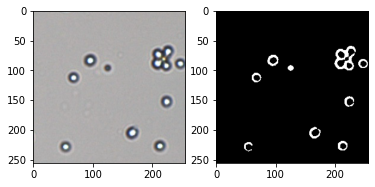

In [47]:
'''Creating an example from the Create_data_set function'''
img_shape = (256,256,3)
img, test_image = create_data_set("Image_001.jpg", img_shape[0], img_shape[1])
figure , axis = plt.subplots(1,2)
#print(np.shape(img))
#print(np.shape(test_image))
axis[0].imshow(img,)
axis[1].imshow(test_image[:,:,0],cmap = "gray")

#print(img)
#print(test_image[0,0,0])



---


##**Importing all the images into Google Collab using glob**

In [ ]:
x_list = [] #To create a list of images
y_list = [] #To create a list of labels
img_shape = (256,256,3)

for image in tqdm(glob.glob("*.jpg")):
  num_images = 70 #why is this 70?
  for i in range(num_images):
    x,y  = create_data_set(image , img_shape[0], img_shape[1])
    x_list.append(x) #Appending all the images into x_list
    y_list.append(y) #Apeending all the labels into y_list
  print(f"Image : {image} completed")
x_list = np.array(x_list)
y_list = np.array(y_list)

#print(np.shape(x))
#print(np.shape(y))



---


## **The Model**

In [9]:
#l2 = keras.regularizers.l2(1e-5)
l2 = None
inputs = keras.Input(shape=img_shape)
conv1 = keras.layers.Conv2D(16,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(inputs)
conv1 = keras.layers.BatchNormalization(momentum=0.99)(conv1)
conv2 = keras.layers.Conv2D(32,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(conv1)
conv2 = keras.layers.BatchNormalization(momentum=0.99)(conv2)
outputs = keras.layers.Conv2D(1,5,padding='same',activation='relu',kernel_initializer='glorot_normal',kernel_regularizer=l2)(conv2)
model = keras.Model(inputs=inputs, outputs=outputs)
model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      12832     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 1)       801   

In [8]:
def test_batch(image_name, height, width):
  img, label = create_data_set(image_name, img_shape[0], img_shape[1])
  return np.expand_dims(img,0), np.expand_dims(label,0)
#Adds an extra dimension to the images and labels, which is the batch-size  

In [10]:
'''The loss function'''
def loss_function(y_true, y_pred): 
  squared_diff = tf.square(y_true - y_pred)
  print(type(squared_diff))
  return tf.reduce_mean(squared_diff)

#x_list.shape

In [11]:
'''The Adam Optimizer'''
opt = keras.optimizers.Adam(learning_rate=1e-4)
model.compile(optimizer=opt,loss=loss_function)

In [ ]:
'''Running the model and saving it'''
'''Un-comment to train and save the model'''
#model.fit(x_list,y_list,batch_size=100,epochs=100)
#model.save(model_path+"/_ADD_YOUR_MODEL_NAME.h5")



---

## **Loading Trained Model**

In [13]:
new_model = tf.keras.models.load_model(path_model+'/myModel_15_1_2022_17_50.h5',custom_objects= {"loss_function":loss_function})
new_model.summary()

Model: "model"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 256, 256, 3)]     0         
                                                                 
 conv2d (Conv2D)             (None, 256, 256, 16)      1216      
                                                                 
 batch_normalization (BatchN  (None, 256, 256, 16)     64        
 ormalization)                                                   
                                                                 
 conv2d_1 (Conv2D)           (None, 256, 256, 32)      12832     
                                                                 
 batch_normalization_1 (Batc  (None, 256, 256, 32)     128       
 hNormalization)                                                 
                                                                 
 conv2d_2 (Conv2D)           (None, 256, 256, 1)       801   



---



## **Testing the model on a part of the image**

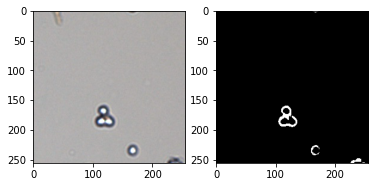

In [15]:
path = "train_image_path"
img, label = test_batch(path,img_shape[0], img_shape[1])

figure , axis = plt.subplots(1,2)
#print(np.shape(img))
#print(np.shape(label))
axis[0].imshow(img[0])
axis[1].imshow(label[0,:,:,0], cmap = "gray")

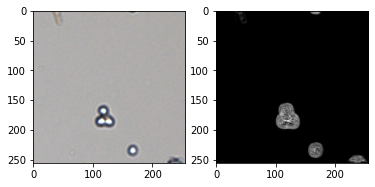

In [16]:
y_pred = new_model.predict(img)
#print(y_pred.max())

figure , axis = plt.subplots(1,2)

axis[0].imshow(img[0])
axis[1].imshow(y_pred[0,:,:,0], cmap = "gray")

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


5 cells are present in this image


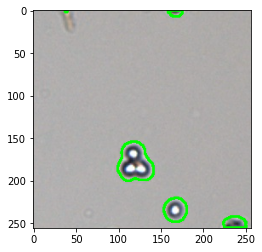

In [17]:
'''counting the number of cells per image'''
y_pred_copy = np.uint8(y_pred*255) #using no.uint8 because blur function only takes integers as input
#print(np.shape(y_pred_copy))
#print(y_pred_copy[0,0,0,0])
label = (label*255).astype(np.uint8) #Denormalising the prediction and the label 
#print(label[0,0,0,0])

blur = cv2.blur(y_pred_copy[0], (10, 10)) #Blur image to reduce noise
ret, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_OTSU) #Otsu's method avoids having to choose a value and determines the threshold automatically
contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
cv2.drawContours(img[0], contours, -1, (0,255,0), 2)

print(str(len(contours))+ " cells are present in this image")
plt.imshow(img[0])

---
## **Creating and testing a sliding window**

(1537, 1537, 3)
Total number of cells: 258


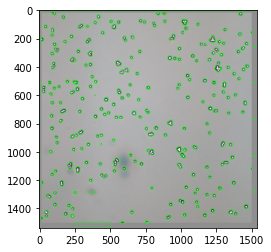

In [18]:
image = cv2.imread("train_image_path") 

'''Padding around the image with grey such that none of the part is skipped by the sliding window'''
img_test = np.zeros((1537,1537,3),dtype=np.uint8)
print(np.shape(img_test))
img_test[18:1518,18:1518,:] = image
img_test[0:1537,0:18, :] = [143,143,143] 
img_test[0:18,0:1537, :] = [143,143,143]
img_test[0:1537,1500:1537, :] = [143,143,143]
img_test[1500:1537, 0:1537, :] = [143,143,143]
#plt.imshow(img_test)
#plt.show()

num_of_cells = 0 #initializing variable to count number of cells
new_model = tf.keras.models.load_model(path_model+'/myModel_15_1_2022_17_50.h5',custom_objects= {"loss_function":loss_function})

# reading the image and defining the stepSize and window-size ==> (width,height)
tmp = img_test #for drawing a rectangle on the image for test purposes
stepSize = 256
(w_width, w_height) = (256, 256) # window size
for x in range(0, img_test.shape[1] - w_width , stepSize): 
   '''StepSize indicates how many pixels we are going to “skip” in both the (x, y) direction'''
   for y in range(0, img_test.shape[0] - w_height, stepSize): #handles the actual “sliding” of the window
      window = tmp[x:x + w_width, y:y + w_height, :] 	
      '''Defines the width and height (in terms of pixels) of the window to extract from the image 
         returns a tuple containing the x and y coordinates of the sliding window, along with the window itself'''
      window = (window/255.0).astype(float) #Normalizing because this sliding window function messes the scaling of the image for prediction by the model
      img = np.expand_dims(window,0)
      y_pred_test = new_model.predict(img)

 
      #cv2.rectangle(tmp, (x, y), (x + w_width, y + w_height), (255, 0, 0), 2) # draws a rectangle or window on an image
      
      #figure , axis = plt.subplots(1,2)
      #axis[0].imshow(window)
      #axis[1].imshow(y_pred_test[0,:,:,0], cmap = "gray")

      y_pred_test = (y_pred_test*255.0).astype('uint8')
      blur = cv2.blur(y_pred_test[0], (10, 10))
      ret, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_OTSU)
      contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
      cv2.drawContours(img_test[x:x+w_height,y:y+w_height], contours, -1, (0,255,0), 2)

      num_of_cells = num_of_cells + len(contours) 

      '''Un-comment to print for each window within the image'''
      #print(np.shape(window))
      #print(np.shape(y_pred_test))
      #plt.imshow(np.array(tmp).astype('uint8'))

'''to show all windows being drawn on an image comment-out "plt.show()"'''
#plt.imshow(img_test)

print("Total number of cells: " +str(num_of_cells))
plt.imshow(img_test)



---
## **Using Trained Model on Testing Images to count number of cells**

In [93]:
path_test_images = "give_path_of_images_to_be_tested_with"
path_results = "result_folder_path"


result_arr = [["File Name", "Number of cells predicted"]]

for image_path in glob.glob(path_test_images):
  image = cv2.imread(image_path) 
  
  img_test = np.zeros((1537,1537,3),dtype=np.uint8)
  img_test[18:1518,18:1518,:] = image
  img_test[0:1537,0:18, :] = [143,143,143] 
  img_test[0:18,0:1537, :] = [143,143,143]
  img_test[0:1537,1500:1537, :] = [143,143,143]
  img_test[1500:1537, 0:1537, :] = [143,143,143]

  num_of_cells = 0 
  new_model = tf.keras.models.load_model(path_model+'/myModel_15_1_2022_17_50.h5',custom_objects= {"loss_function":loss_function})

  tmp = img_test
  stepSize = 256
  (w_width, w_height) = (256, 256)
  for x in range(0, img_test.shape[1] - w_width , stepSize): 
    for y in range(0, img_test.shape[0] - w_height, stepSize): 
        window = tmp[x:x + w_width, y:y + w_height, :] 	
        window = (window/255.0).astype(float) 
        img = np.expand_dims(window,0)
        y_pred_test = new_model.predict(img)
        y_pred_test = (y_pred_test*255.0).astype('uint8')
        blur = cv2.blur(y_pred_test[0], (10, 10))
        ret, thresh = cv2.threshold(blur, 1, 255, cv2.THRESH_OTSU)
        contours, heirarchy = cv2.findContours(thresh, cv2.RETR_TREE, cv2.CHAIN_APPROX_SIMPLE)
        cv2.drawContours(img_test[x:x+w_height,y:y+w_height], contours, -1, (0,255,0), 2)
        num_of_cells = num_of_cells + len(contours) 
  
  
  file_name = os.path.basename(image_path)
  print("Image "+file_name)
  print("Total number of cells: " +str(num_of_cells))
  
  
  #cv2.imwrite(path_results+ "Result_" +file_name, img_test)

  result_arr.append([file_name, num_of_cells])

df_result = pd.DataFrame(result_arr)
df_result.to_csv(path_results+"results.csv",index= False,header=False)
print(df_result)

Image Image_017.jpg
Total number of cells: 207
Image Image_020.jpg
Total number of cells: 225
Image Image_019.jpg
Total number of cells: 236
Image Image_016.jpg
Total number of cells: 276
Image Image_018.jpg
Total number of cells: 267
               0                          1
0      File Name  Number of cells predicted
1  Image_017.jpg                        207
2  Image_020.jpg                        225
3  Image_019.jpg                        236
4  Image_016.jpg                        276
5  Image_018.jpg                        267
